In [29]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Annotated
from langchain_ollama import ChatOllama
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langchain_core.messages import SystemMessage, HumanMessage
import operator

load_dotenv()

True

In [30]:
model_generator = ChatOllama(model="llama3")
# model_qween = ChatOllama(model="qwen3:4b")
model_evaluator = ChatOllama(model="gemma3")
model_optimizor = ChatGoogleGenerativeAI(model="models/gemini-flash-latest")


In [31]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [32]:
structured_evaluator_llm = model_evaluator.with_structured_output(TweetEvaluation)

In [33]:
class TweetState(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal['approved', 'needs_improvement']
    feedback: str
    iteration: int
    max_iterations: int

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [34]:
def generate_tweet(state: TweetState):
    # prompt
    messages = [
            SystemMessage(content="You are a funny and clever Twitter/X influencer."),
            HumanMessage(content=f"""
    Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

    Rules:
    - Do NOT use question-answer format.
    - Max 280 characters.
    - Use observational humor, irony, sarcasm, or cultural references.
    - Think in meme logic, punchlines, or relatable takes.
    - Use simple, day to day english
    - This is version {state['iteration'] + 1 }.
    """)
        ]
    # send generator_llm
    response = model_generator.invoke(messages).content

    # return response
    return { 'tweet': response, 'tweet_history': [response]}

In [35]:
def evaluate_tweet(state: TweetState):
    messages = [
         SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
         HumanMessage(content=f"""
            Evaluate the following tweet:
            Tweet: "{state['tweet']}"

            Use the criteria below to evaluate the tweet:

            1. Originality – Is this fresh, or have you seen it a hundred times before?
            2. Humor – Did it genuinely make you smile, laugh, or chuckle?
            3. Punchiness – Is it short, sharp, and scroll-stopping?
            4. Virality Potential – Would people retweet or share it?
            5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

            Auto-reject if:
            - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
            - It exceeds 280 characters
            - It reads like a traditional setup-punchline joke
            - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

            ### Respond ONLY in structured format:
            - evaluation: "approved" or "needs_improvement"
            - feedback: One paragraph explaining the strengths and weaknesses
            """
            )
        ]

    response = structured_evaluator_llm.invoke(messages)

    return {'evaluation':response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

In [36]:
def optimize_tweet(state: TweetState):
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
            Improve the tweet based on this feedback:
            "{state['feedback']}"

            Topic: "{state['topic']}"
            Original Tweet:
            {state['tweet']}

            Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
            """)
        ]

    response = model_optimizor.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

In [37]:
def route_evaluation(state: TweetState):
    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iterations']:
        return 'approved'
    else:
        return 'needs_improvement'

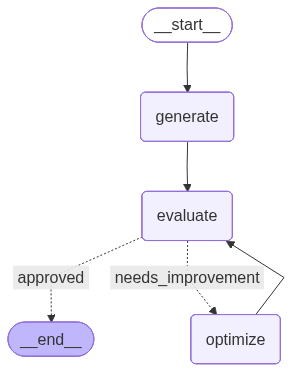

In [38]:
graph = StateGraph(TweetState)

graph.add_node('generate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)

graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')

graph.add_conditional_edges('evaluate', route_evaluation, {'approved': END, 'needs_improvement': 'optimize'})
graph.add_edge('optimize', 'evaluate')

workflow = graph.compile()
workflow

In [39]:
inital_state = {
    'topic': 'Inidan Railways',
    'iteration': 1,
    'max_iterations': 5
}

result = workflow.invoke(inital_state)

In [40]:
result

{'topic': 'Inidan Railways',
 'tweet': '**Improved Tweet:**\n\nIndian Railways late update: The uncle next to me has moved from asking about my salary to calculating my retirement fund.\n\n#IndianRailways #TrainDelay #IRCTC',
 'evaluation': 'needs_improvement',
 'feedback': 'This tweet relies on a very common and somewhat tired observational joke about Indian Railways passengers. While the scenario – the overly inquisitive relative – *could* be amusing, the execution lacks punch and feels like a setup for a predictable punchline. It’s currently a bland recounting of a relatable experience, not a witty observation. The brevity is good, but it needs a sharper delivery or a specific detail to elevate it beyond a standard, uninspired anecdote. It needs something to truly *stick*.” ランク：３/５（４点に近づける可能性がある）',
 'iteration': 5,
 'max_iterations': 5,
 'tweet_history': ['"Indian Railways: where the only thing more reliable than the punctuality is the smell of stale samosas and regret #RailwayLife 

In [41]:
for tweet in result['tweet_history']:
    print(tweet)

"Indian Railways: where the only thing more reliable than the punctuality is the smell of stale samosas and regret #RailwayLife #SamosaSyllabus"
**Indian Railways doesn't run late. It just operates on 'Existential Standard Time'—the moment you accept your fate and start sharing your snacks with the uncle who took your seat.**

#IRCTC #SurvivalCourse
[{'type': 'text', 'text': "Indian Railways doesn't run late. It operates on IRCTC Time: The precise moment you stop checking the ETA and start planning your retirement with the uncle sharing his chips.", 'extras': {'signature': 'Cs4ZAXLI2nysaUAbU+HP7mcp9S1ndXOxcf2gjAiAipD7jg4be3bqOT5Z05zEQSs8angrxxn0k8qWsFNty3Bvsa61Q5lAelDYNwA1IyiZuN+dKfL/xlvtTApCU8HiwchZE/eQcta8x5z6p9BRJEKTWM73jDvAwyWukGAuY7AdGoReotxuMcfl3inXpOzqvOawXGsGvLHdud6qNrIjiOj2J9wnWE7V2dLx6Bi4EzAPhh9lUDaHpWgyR/mIARFSLfPSymIHOfd1jVcN51Cx0YJWzowE+iw9YxWCbw85+KEaZ/yoQu6GTQNeGyTCwnVKMACVgfB1z38JhGGza4nzj+iOhNT9fAdqKZ/Vx0g7t6M+gBGRJqNH5jaQBlVHY+uJ49m0K+mCuyVrQqQzSLBojXTFwBNQ+b8YDP2inbf